In [541]:
# Data source API
from ucimlrepo import fetch_ucirepo

# Data Anaylsis
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.formula.api as smf
import sklearn.metrics as metrics
import sklearn.linear_model as sklm

# Data visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import font_manager
from matplotlib.cm import get_cmap
import seaborn as sns

In [542]:
# Matplotlib global params
font_files = font_manager.findSystemFonts(fontpaths="Roboto")

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

plt.style.use("ggplot")
plt.rcParams["image.cmap"] = 'viridis'
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Roboto"]
plt.rcParams["figure.titleweight"] = "bold"
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["legend.facecolor"] = "white"
plt.rcParams["legend.edgecolor"] = "white"
plt.rcParams["boxplot.flierprops.markeredgewidth"] = 0
plt.rcParams["boxplot.flierprops.markerfacecolor"] = "black"
plt.rcParams["boxplot.flierprops.markersize"] = 5.0
plt.rcParams["boxplot.medianprops.color"] = "black"

# Constants
zones = ["zone_1_power", "zone_2_power", "zone_3_power"]

common_feats = ["temperature",
                "humidity",
                "wind_speed",
                "general_diffuse_flows",
                "diffuse_flows"]

viridis_zones = get_cmap('viridis', len(zones))
viridis_cf = get_cmap('viridis', len(common_feats))

/var/folders/29/b1zgt_4148qbjk0pt48_ybym0000gn/T/ipykernel_74150/1200486544.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis_zones = get_cmap('viridis', len(zones))
/var/folders/29/b1zgt_4148qbjk0pt48_ybym0000gn/T/ipykernel_74150/1200486544.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis_cf = get_cmap('viridis', len(common_feats))


In [174]:
print(plt.rcParams)

_internal.classic_mode: False
agg.path.chunksize: 0
animation.bitrate: -1
animation.codec: h264
animation.convert_args: ['-layers', 'OptimizePlus']
animation.convert_path: convert
animation.embed_limit: 20.0
animation.ffmpeg_args: []
animation.ffmpeg_path: ffmpeg
animation.frame_format: png
animation.html: none
animation.writer: ffmpeg
axes.autolimit_mode: data
axes.axisbelow: True
axes.edgecolor: white
axes.facecolor: #E5E5E5
axes.formatter.limits: [-5, 6]
axes.formatter.min_exponent: 0
axes.formatter.offset_threshold: 4
axes.formatter.use_locale: False
axes.formatter.use_mathtext: False
axes.formatter.useoffset: True
axes.grid: True
axes.grid.axis: both
axes.grid.which: major
axes.labelcolor: #555555
axes.labelpad: 4.0
axes.labelsize: large
axes.labelweight: bold
axes.linewidth: 1.0
axes.prop_cycle: cycler('color', ['#E24A33', '#348ABD', '#988ED5', '#777777', '#FBC15E', '#8EBA42', '#FFB5B8'])
axes.spines.bottom: True
axes.spines.left: True
axes.spines.right: True
axes.spines.top: Tru

# Data Pre-processing

In [175]:
# Pull in remote dataset from UCI ML repo
raw_data = fetch_ucirepo(id=849)

In [499]:
# Create flat table
raw_df: pd.DataFrame = raw_data.data.features.merge(raw_data.data.targets,
                                                    how='outer',
                                                    left_index=True,
                                                    right_index=True)

# Relabeling with friendly column headers
new_colnames = ["datetime",
                "temperature",
                "humidity",
                "wind_speed",
                "general_diffuse_flows",
                "diffuse_flows",
                "zone_1_power",
                "zone_2_power",
                "zone_3_power"]

colname_updates = {orig_colnames: new_colnames for orig_colnames,
                   new_colnames in zip(raw_df.columns, new_colnames)}

tetoun_power: pd.DataFrame = raw_df.rename(columns=colname_updates)

# Feature Engineering
tetoun_power["datetime"] = pd.to_datetime(tetoun_power["datetime"])

tetoun_power["total_power"] = tetoun_power["zone_1_power"] + \
    tetoun_power["zone_2_power"] + tetoun_power["zone_3_power"]

tetoun_power = tetoun_power.assign(
    year=tetoun_power["datetime"].dt.year,
    month=tetoun_power["datetime"].dt.month,
    day=tetoun_power["datetime"].dt.day,
    hour=tetoun_power["datetime"].dt.hour,
    minute=tetoun_power["datetime"].dt.minute,
    minute_of_day=tetoun_power["datetime"].dt.hour *
    tetoun_power["datetime"].dt.minute + 60,
    day_of_week=tetoun_power["datetime"].dt.dayofweek,
    day_of_year=tetoun_power["datetime"].dt.dayofyear,
    weekofyear=tetoun_power["datetime"].dt.isocalendar().week,
    zone_1_2wma=tetoun_power["zone_1_power"].rolling(window=72).mean(),
    zone_1_1mma=tetoun_power["zone_1_power"].rolling(window=144).mean(),
    zone_1_2mma=tetoun_power["zone_1_power"].rolling(window=288).mean(),
    zone_1_3mma=tetoun_power["zone_1_power"].rolling(window=432).mean(),
    zone_1_6mma=tetoun_power["zone_1_power"].rolling(window=864).mean(),
    zone_2_6mma=tetoun_power["zone_2_power"].rolling(window=864).mean(),
    zone_3_6mma=tetoun_power["zone_3_power"].rolling(window=864).mean(),
    total_power_6mma=tetoun_power["total_power"].rolling(window=864).mean()
)

# Exploratory Data Analysis

In [177]:
tetoun_power.head(3)

,datetime,temperature,humidity,wind_speed,general_diffuse_flows,diffuse_flows,zone_1_power,zone_2_power,zone_3_power,total_power,...,day_of_year,weekofyear,zone_1_2wma,zone_1_1mma,zone_1_2mma,zone_1_3mma,zone_1_6mma,zone_2_6mma,zone_3_6mma,total_power_6mma
0,2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386,70425.53544,...,1,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434,69320.84387,...,1,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373,67803.22193,...,1,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [178]:
# Summary statistics for power consumption in each zone
summary_stats = tetoun_power[["zone_1_power",
                              "zone_2_power", "zone_3_power"]].describe()
print(summary_stats)

       zone_1_power  zone_2_power  zone_3_power
count  52416.000000  52416.000000  52416.000000
mean   32344.970564  21042.509082  17835.406218
std     7130.562564   5201.465892   6622.165099
min    13895.696200   8560.081466   5935.174070
25%    26310.668692  16980.766032  13129.326630
50%    32265.920340  20823.168405  16415.117470
75%    37309.018185  24713.717520  21624.100420
max    52204.395120  37408.860760  47598.326360


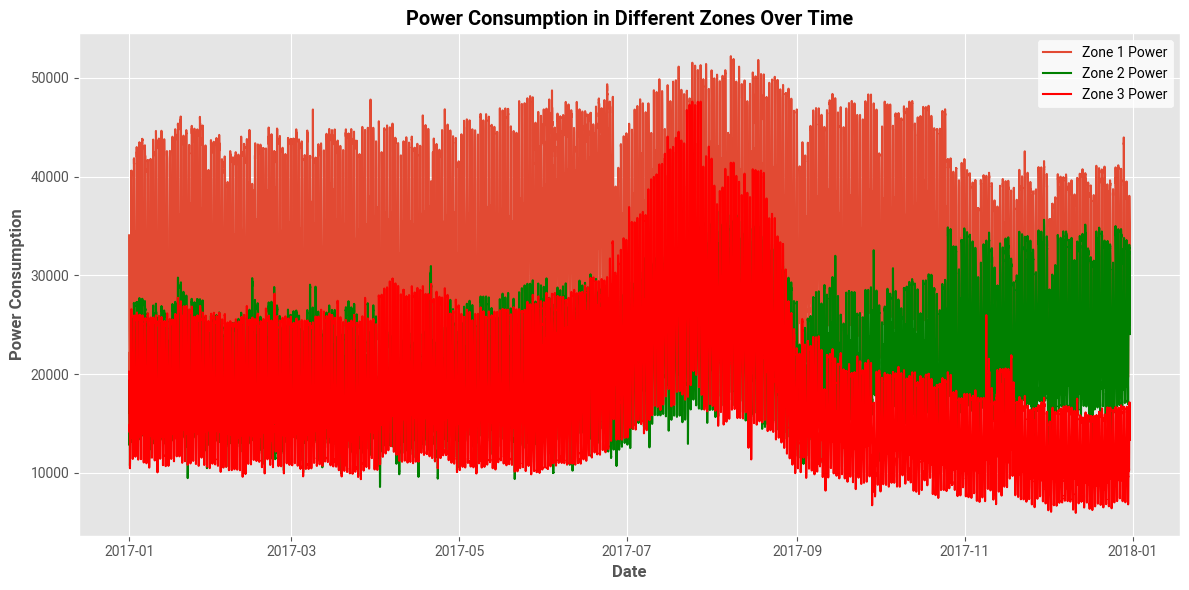

In [179]:
# Time series plot for power consumption in each zone
plt.figure(figsize=(12, 6))
plt.plot(tetoun_power["datetime"],
         tetoun_power["zone_1_power"], label="Zone 1 Power")
plt.plot(tetoun_power["datetime"], tetoun_power["zone_2_power"],
         label="Zone 2 Power", color="green")
plt.plot(tetoun_power["datetime"], tetoun_power["zone_3_power"],
         label="Zone 3 Power", color="red")
plt.xlabel('Date')
plt.ylabel('Power Consumption')
plt.title('Power Consumption in Different Zones Over Time')
plt.legend()
plt.tight_layout()
plt.show()

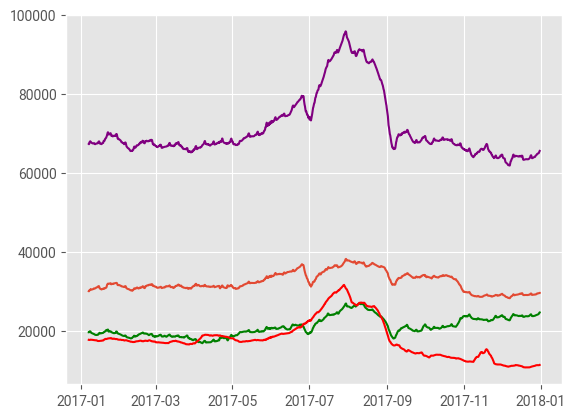

In [180]:
fig, ax = plt.subplots()

ax.plot(tetoun_power["datetime"], tetoun_power["zone_1_6mma"])
ax.plot(tetoun_power["datetime"], tetoun_power["zone_2_6mma"], color="green")
ax.plot(tetoun_power["datetime"], tetoun_power["zone_3_6mma"], color="red")
ax.plot(tetoun_power["datetime"],
        tetoun_power["total_power_6mma"], color="purple")

plt.show()

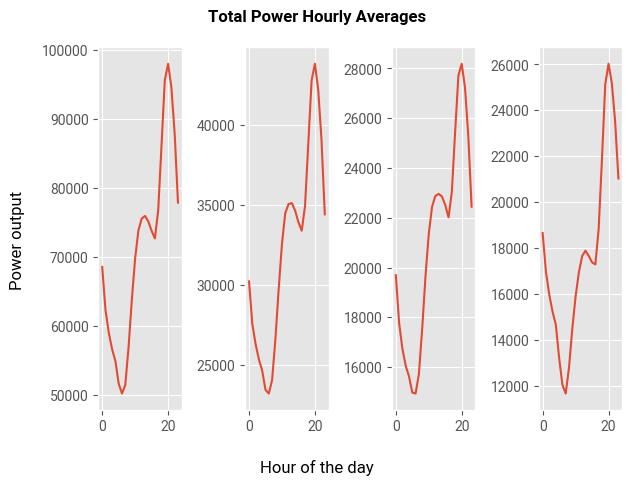

In [181]:
tp_hourly_avg = tetoun_power.groupby("hour").agg({"total_power": "mean"})
z1_hourly_avg = tetoun_power.groupby("hour").agg({"zone_1_power": "mean"})
z2_hourly_avg = tetoun_power.groupby("hour").agg({"zone_2_power": "mean"})
z3_hourly_avg = tetoun_power.groupby("hour").agg({"zone_3_power": "mean"})

fig, ax = plt.subplots(1, 4)

ax[0].plot(np.arange(0, 24, 1), tp_hourly_avg["total_power"])
ax[1].plot(np.arange(0, 24, 1), z1_hourly_avg["zone_1_power"])
ax[2].plot(np.arange(0, 24, 1), z2_hourly_avg["zone_2_power"])
ax[3].plot(np.arange(0, 24, 1), z3_hourly_avg["zone_3_power"])

fig.suptitle("Total Power Hourly Averages")
fig.supylabel("Power output")
fig.supxlabel("Hour of the day")
fig.tight_layout()
plt.show()

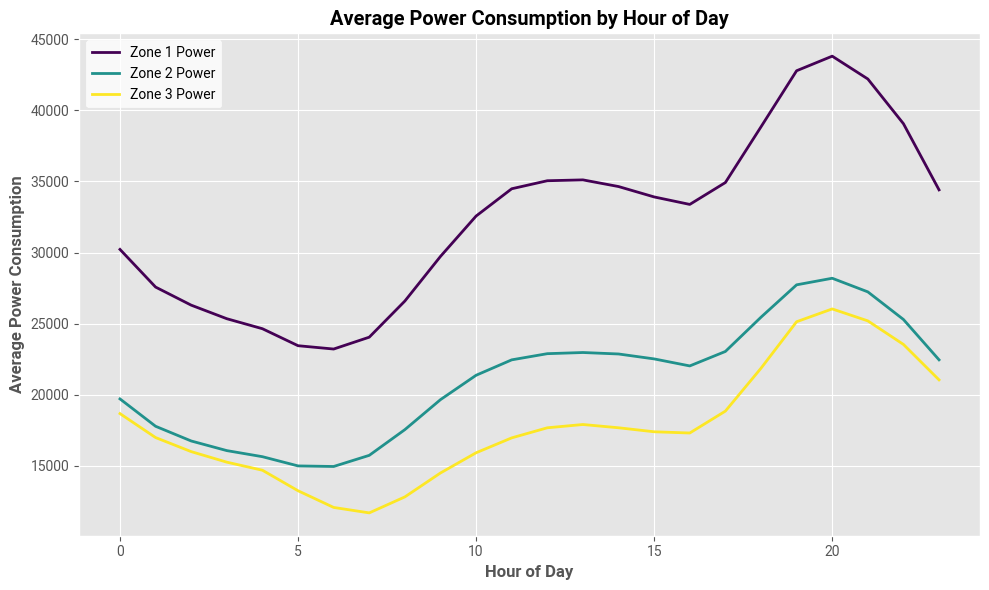

In [299]:
# Average power consumption by hour of the day
avg_power_by_hour = tetoun_power.groupby(
    "hour")[["zone_1_power", "zone_2_power", "zone_3_power"]].mean()

# Define zone names and colors in a list to avoid repetition
colors = viridis_zones(np.linspace(0, 1, len(zones)))

# Plot the average power consumption by hour of the day
plt.figure(figsize=(10, 6))

# Use a loop to plot each zone's data
for zone, color in zip(zones, colors):
    plt.plot(avg_power_by_hour.index,
             avg_power_by_hour[zone], label=f"{zone.replace('_', ' ').title()}", color=color, linewidth=2)

plt.xlabel('Hour of Day')
plt.ylabel('Average Power Consumption')
plt.title('Average Power Consumption by Hour of Day')
plt.legend()
plt.tight_layout()
plt.show()

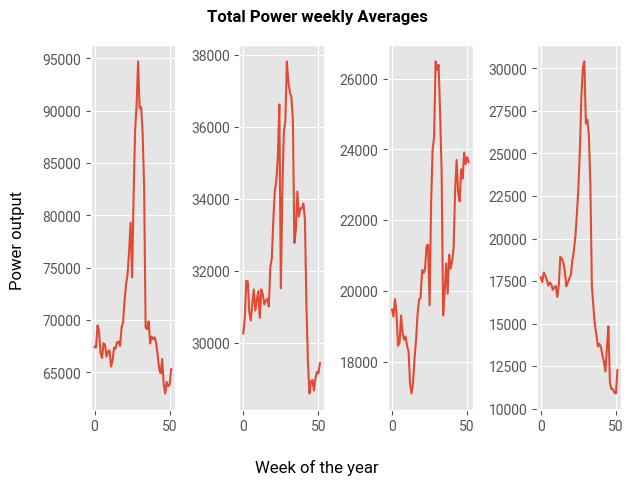

In [183]:
tp_weekly_avg = tetoun_power.groupby("weekofyear").agg({"total_power": "mean"})
z1_weekly_avg = tetoun_power.groupby(
    "weekofyear").agg({"zone_1_power": "mean"})
z2_weekly_avg = tetoun_power.groupby(
    "weekofyear").agg({"zone_2_power": "mean"})
z3_weekly_avg = tetoun_power.groupby(
    "weekofyear").agg({"zone_3_power": "mean"})

fig, ax = plt.subplots(1, 4)

ax[0].plot(np.arange(0, 52, 1), tp_weekly_avg["total_power"])
ax[1].plot(np.arange(0, 52, 1), z1_weekly_avg["zone_1_power"])
ax[2].plot(np.arange(0, 52, 1), z2_weekly_avg["zone_2_power"])
ax[3].plot(np.arange(0, 52, 1), z3_weekly_avg["zone_3_power"])

fig.suptitle("Total Power weekly Averages")
fig.supylabel("Power output")
fig.supxlabel("Week of the year")
fig.tight_layout()
plt.show()

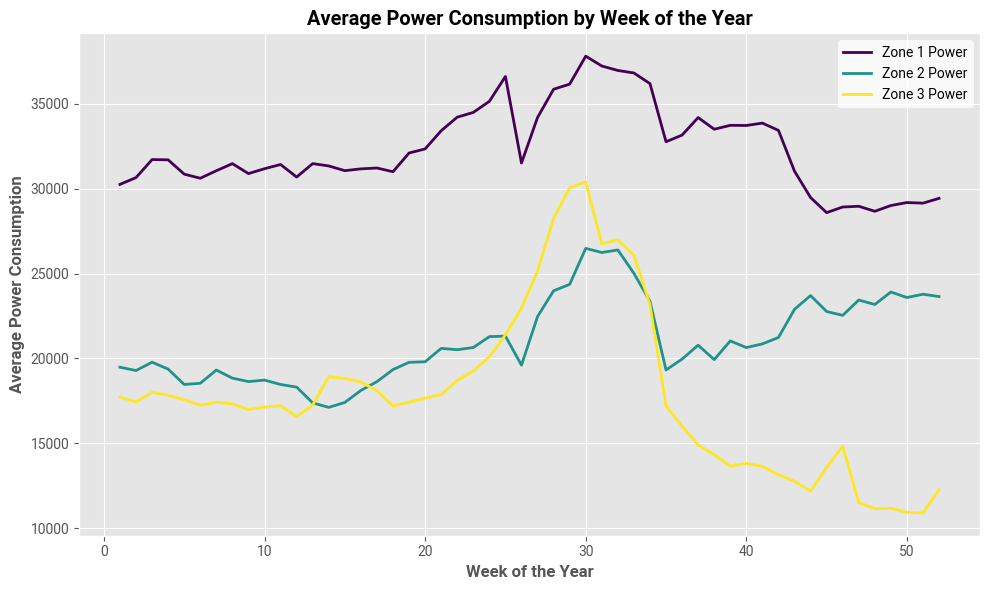

In [301]:
# Calculate the weekly mean power consumption for each zone
avg_power_by_week = tetoun_power.groupby(
    "weekofyear")[["zone_1_power", "zone_2_power", "zone_3_power"]].mean()

# Set color mapping
colors = viridis_zones(np.linspace(0, 1, len(zones)))

# Plot the average power consumption by week of the year
plt.figure(figsize=(10, 6))

# Use a loop to plot each zone's data with viridis colors
for zone, color in zip(zones, colors):
    plt.plot(avg_power_by_week.index,
             avg_power_by_week[zone], label=f"{zone.replace('_', ' ').title()}", color=color, linewidth=2)

# Add labels and title
plt.xlabel('Week of the Year')
plt.ylabel('Average Power Consumption')
plt.title('Average Power Consumption by Week of the Year')
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

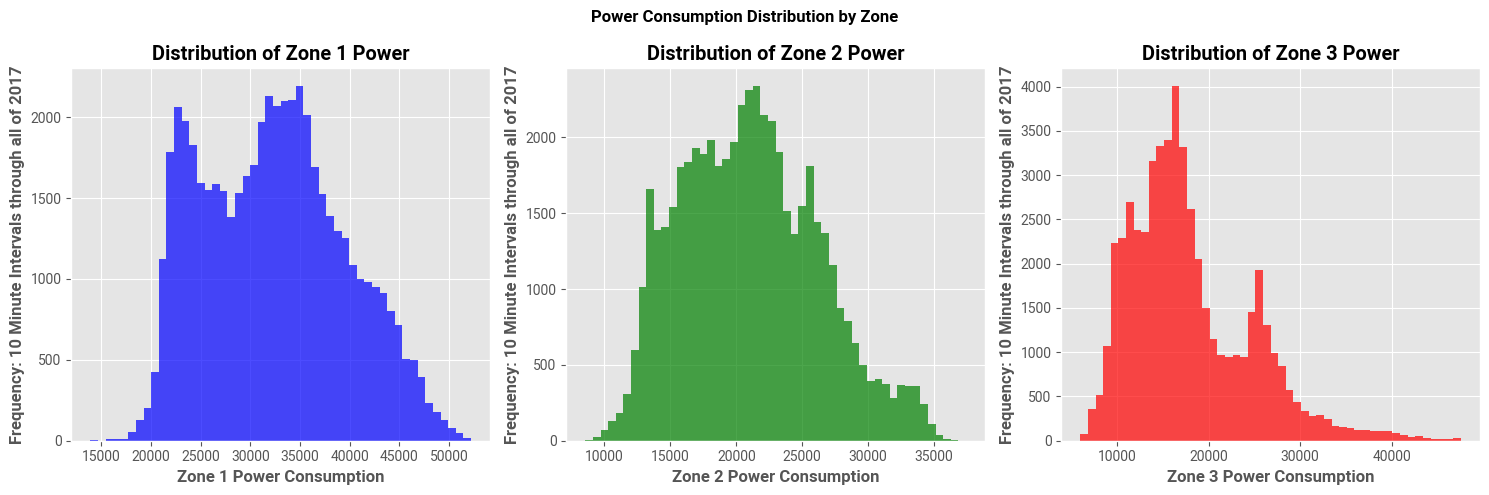

In [302]:
# Create a distribution chart for each power zone
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Distribution for Zone 1 Power
ax[0].hist(tetoun_power["zone_1_power"], bins=50, alpha=0.7, color='blue')
ax[0].set_title('Distribution of Zone 1 Power')
ax[0].set_xlabel('Zone 1 Power Consumption')
ax[0].set_ylabel('Frequency: 10 Minute Intervals through all of 2017')

# Distribution for Zone 2 Power
ax[1].hist(tetoun_power["zone_2_power"], bins=50, alpha=0.7, color='green')
ax[1].set_title('Distribution of Zone 2 Power')
ax[1].set_xlabel('Zone 2 Power Consumption')
ax[1].set_ylabel('Frequency: 10 Minute Intervals through all of 2017')

# Distribution for Zone 3 Power
ax[2].hist(tetoun_power["zone_3_power"], bins=50, alpha=0.7, color='red')
ax[2].set_title('Distribution of Zone 3 Power')
ax[2].set_xlabel('Zone 3 Power Consumption')
ax[2].set_ylabel('Frequency: 10 Minute Intervals through all of 2017')

fig.suptitle('Power Consumption Distribution by Zone')
plt.tight_layout()
plt.show()

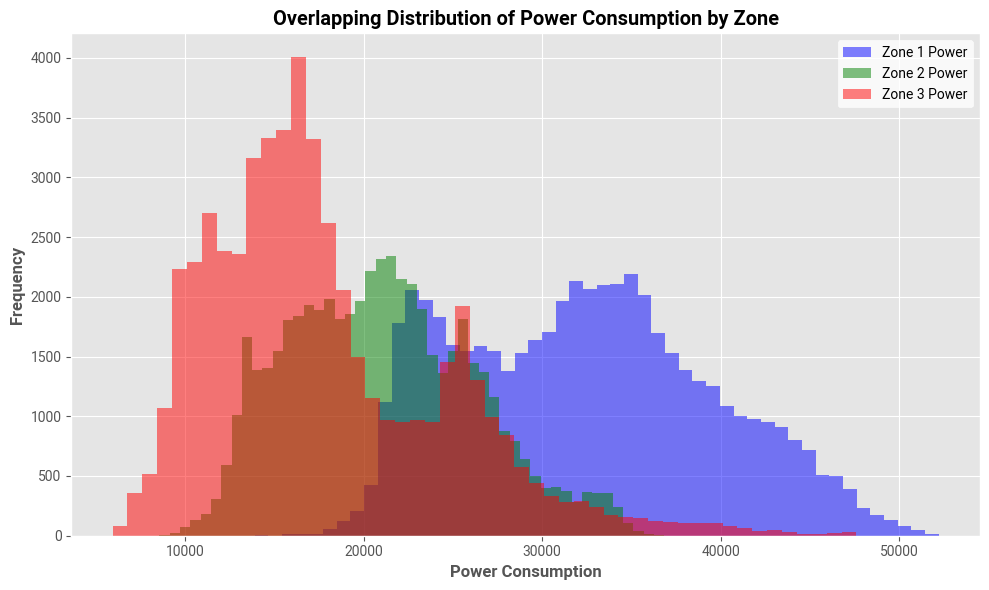

In [186]:
# Create an overlapping distribution chart for all three zones
fig, ax = plt.subplots(figsize=(10, 6))

# Zone 1 Power
ax.hist(tetoun_power["zone_1_power"], bins=50,
        alpha=0.5, label='Zone 1 Power', color='blue')

# Zone 2 Power
ax.hist(tetoun_power["zone_2_power"], bins=50,
        alpha=0.5, label='Zone 2 Power', color='green')

# Zone 3 Power
ax.hist(tetoun_power["zone_3_power"], bins=50,
        alpha=0.5, label='Zone 3 Power', color='red')

# Add titles and labels
ax.set_title('Overlapping Distribution of Power Consumption by Zone')
ax.set_xlabel('Power Consumption')
ax.set_ylabel('Frequency')
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
# A function to produce sampling distributions of sample means
def sampling_dist_mean(a, n: int, num_samples: int):
    """A function for generating sampling distributions fo sample means

    Args:
        a (np.array | pd.Series): An np.array or pd.Series of data to sample.
        n (int): The number of data points to sample per iteration.
        num_samples (int): The number of sampling iterations.

    Returns:
        np.array: An array of sample means of length num_samples.
    """
    return [np.random.choice(a, size=n).mean() for _ in np.arange(num_samples)]

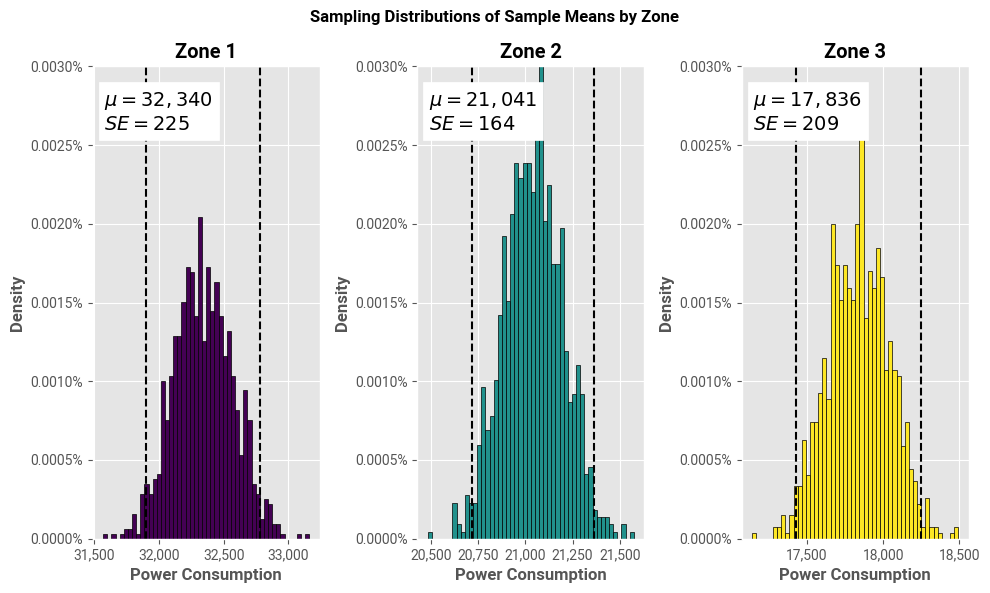

In [665]:
# Simulate random sampling from a uniform distribution for each zone
n = 1000
num_samples = 1000  # Number of random samples

# Create histograms to visualize the uniform distribution for each zone
fig, ax = plt.subplots(1, 3, figsize=(10, 6))
colors = viridis_zones(np.linspace(0, 1, len(zones)))

for i, zone in enumerate(zones):
    data = sampling_dist_mean(tetoun_power[zone], n, num_samples)
    output_space = np.linspace(
        np.min(tetoun_power[zone]), np.max(tetoun_power[zone]), num_samples)

    sd = np.std(tetoun_power[zone])
    mu = np.mean(data)
    se = sd / np.sqrt(n)

    ax[i].hist(data, bins=50, color=colors[i],
               ec="black", density=True)

    ax[i].vlines(mu-1.96*se, 0, 0.014, color="black", linestyles="dashed")
    ax[i].vlines(mu+1.96*se, 0, 0.014, color="black", linestyles="dashed")

    ax[i].set_title(f"Zone {i+1}")
    ax[i].set_xlabel("Power Consumption")
    ax[i].xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax[i].set_ylim([0, 0.003])
    ax[i].yaxis.set_major_formatter(ticker.PercentFormatter(decimals=4))
    ax[i].set_ylabel("Density")

    textstr = '\n'.join((
        r'$\mu={:,.0f}$'.format(mu),
        r'$SE={:.0f}$'.format(se),
    ))
    
    ax[i].text(0.05, 0.95, textstr, transform=ax[i].transAxes, fontsize=14,
               verticalalignment='top', bbox=dict(fc="white", ec="white"))

# Display the charts
fig.suptitle(
    'Sampling Distributions of Sample Means by Zone')
plt.tight_layout()
plt.show()

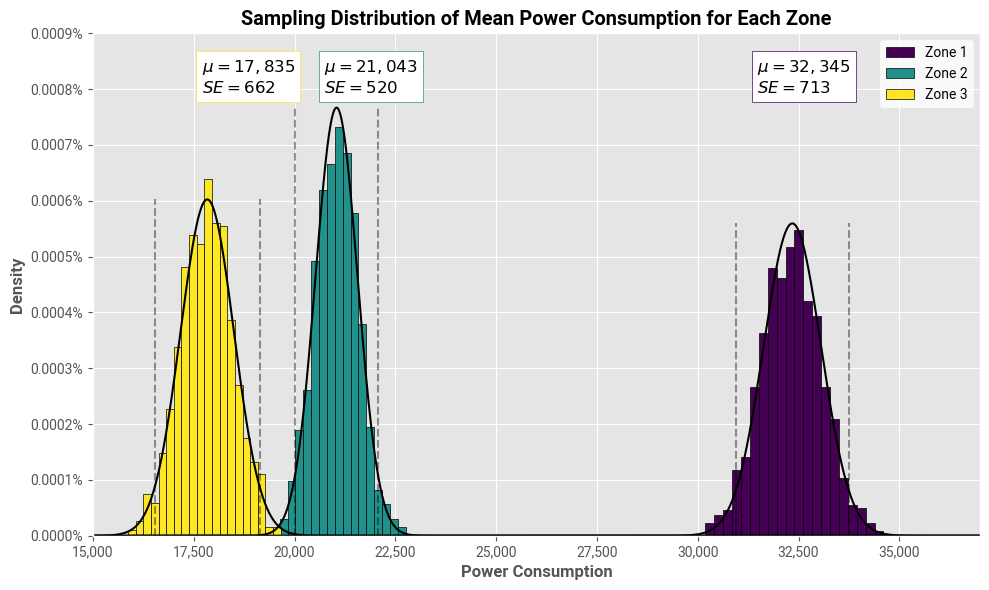

In [544]:
# Sampling and plotting parameters
num_samples = 1000
n = 100

colors = viridis_zones(np.linspace(0, 1, len(zones)))
x_lim = [15000, 37000]
y_lim = [0, .0009]

# Plot the sampling distributions
fig, ax = plt.subplots(figsize=(10, 6))

for i, zone in enumerate(zones):
    # Identify key parameters
    sd = np.std(tetoun_power[zone])
    mu = np.mean(tetoun_power[zone])
    se = sd / np.sqrt(n)

    # Create a normal distribution
    x_vals = np.arange(tetoun_power[zone].min(), tetoun_power[zone].max(), 1)
    norm = stats.norm.pdf(x_vals, loc=mu, scale=se)

    # Create sampling distribution
    sampling_dist = sampling_dist_mean(tetoun_power[zone], n, num_samples)

    ax.hist(sampling_dist, bins=20, density=True,
            color=colors[i], label=f"Zone {i+1}", ec="black", alpha=1)

    #
    ax.plot(x_vals, norm, color="black")

    # Plot 95% confidence intervals
    ax.vlines(mu-1.96*se, 0, norm.max(),
              color="black", linestyles="dashed", alpha=0.4)
    ax.vlines(mu+1.96*se, 0, norm.max(),
              color="black", linestyles="dashed", alpha=0.4)

    # Text boxes
    textstr = '\n'.join((
        r'$\mu={:,.0f}$'.format(mu),
        r'$SE={:.0f}$'.format(se),
    ))

    box_pos = (mu-x_lim[0])/(x_lim[1]-x_lim[0])*.95
    ax.text(box_pos, 0.95, textstr, transform=ax.transAxes, fontsize=12,
            verticalalignment="top",
            bbox=dict(fc="white", ec=colors[i], alpha=1))

# Axis format
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_xlim(x_lim)

ax.yaxis.set_major_formatter(ticker.PercentFormatter(decimals=4))
ax.set_ylim(y_lim)

# Labels, title, and legend
plt.xlabel("Power Consumption")
plt.ylabel("Density")
plt.title(
    "Sampling Distribution of Mean Power Consumption for Each Zone", weight="bold")
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

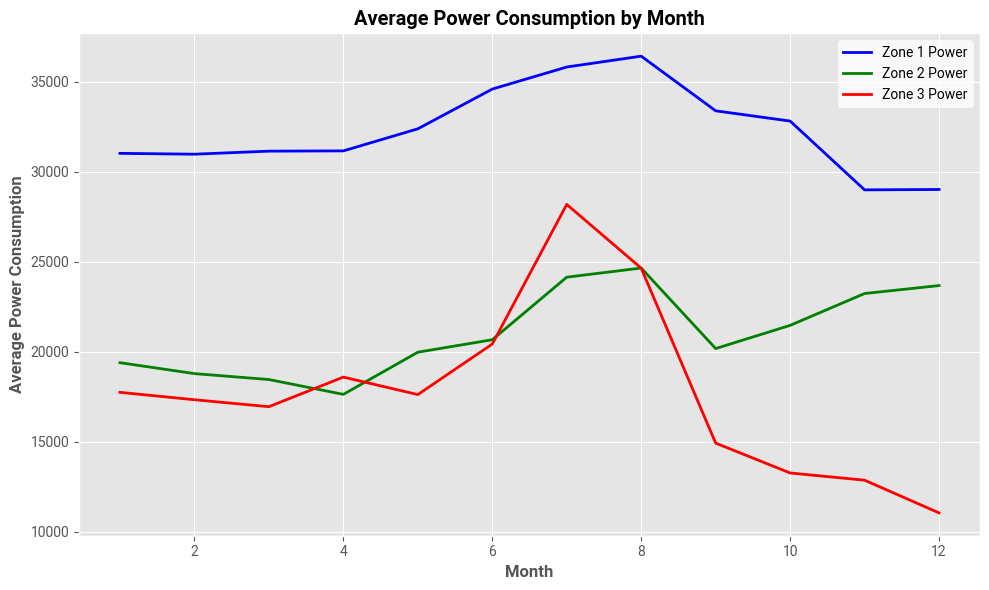

In [189]:
# Group by 'month' and calculate the mean power consumption for each zone
avg_power_by_month = tetoun_power.groupby(
    "month")[["zone_1_power", "zone_2_power", "zone_3_power"]].mean()

# Plot the average power consumption by month with specific colors for each zone
plt.figure(figsize=(10, 6))
plt.plot(avg_power_by_month.index,
         avg_power_by_month["zone_1_power"], label="Zone 1 Power", color="blue", linewidth=2)
plt.plot(avg_power_by_month.index,
         avg_power_by_month["zone_2_power"], label="Zone 2 Power", color="green", linewidth=2)
plt.plot(avg_power_by_month.index,
         avg_power_by_month["zone_3_power"], label="Zone 3 Power", color="red", linewidth=2)

# Add labels and title
plt.xlabel('Month')
plt.ylabel('Average Power Consumption')
plt.title('Average Power Consumption by Month')
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

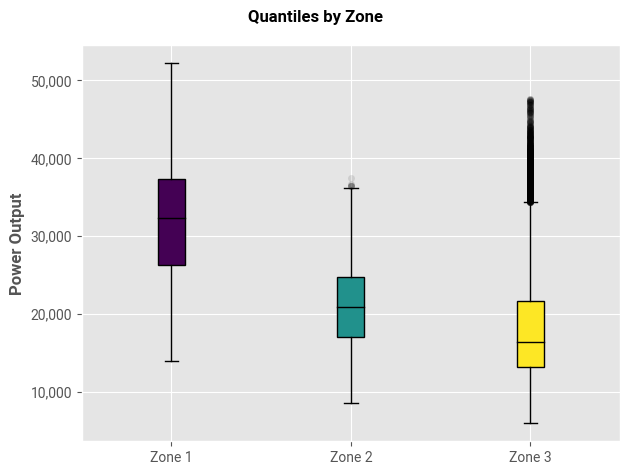

In [586]:
# Quantiles by Zone
colors = viridis_zones(np.linspace(0, 1, len(zones)))

fig, ax = plt.subplots()

[ax.boxplot(tetoun_power[zone], positions=[i+1], patch_artist=True,
            boxprops=dict(facecolor=colors[i]),
            flierprops=dict(alpha=0.1)) for i, zone in enumerate(zones)]

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

ax.set_xticklabels(["Zone 1", "Zone 2", "Zone 3"])
ax.set_ylabel("Power Output")

fig.suptitle("Quantiles by Zone")
fig.tight_layout()
plt.show()

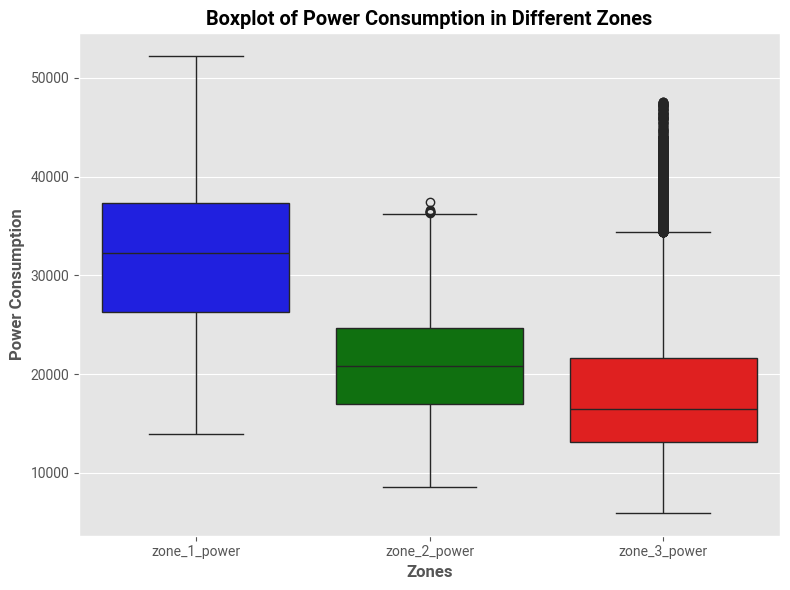

In [191]:
# Redoing the box plot with specific colors for each zone

plt.figure(figsize=(8, 6))

# Creating a boxplot and specifying the colors for each zone
sns.boxplot(data=tetoun_power[["zone_1_power", "zone_2_power", "zone_3_power"]],
            palette={"zone_1_power": "blue", "zone_2_power": "green", "zone_3_power": "red"})

plt.title('Boxplot of Power Consumption in Different Zones')
plt.xlabel('Zones')
plt.ylabel('Power Consumption')
plt.tight_layout()

# Display the plot
plt.show()

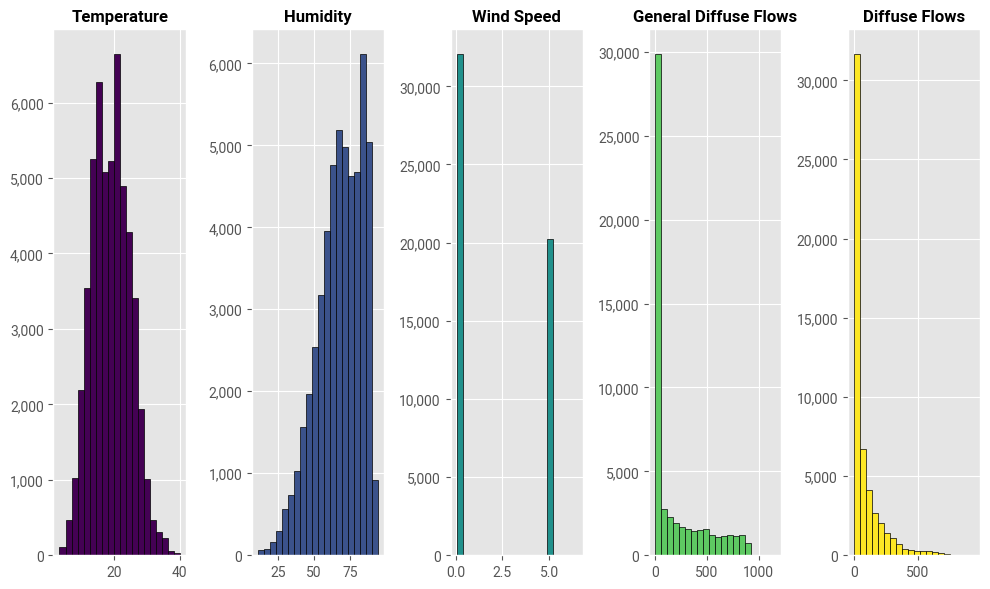

In [587]:
# Plotting histograms for each weather feature
colors = viridis_cf(np.linspace(0, 1, len(common_feats)))

fig, ax = plt.subplots(1, len(common_feats), figsize=(10, 6))

for i, feature in enumerate(common_feats):
    ax[i].hist(tetoun_power[feature], bins=20, color=colors[i], ec="black")
    ax[i].set_title(common_feats[i].replace("_", " ").title(), fontsize=12)
    ax[i].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))


fig.tight_layout()
plt.show()

In [400]:
# Kolmogorov-Smirnov Tests
kst_cols = [{"feature": f, "stat": s, "p-value": p} for f, (s, p) in [(feature, stats.kstest(
    tetoun_power[feature].sample(1000), 'norm')) for feature in common_feats]]

pd.DataFrame(kst_cols)

,feature,stat,p-value
0,temperature,0.999923,0.000000e+00
1,humidity,1.000000,0.000000e+00
2,wind_speed,0.522515,1.136848e-254
3,general_diffuse_flows,0.504984,1.142789e-236
4,diffuse_flows,0.523578,8.664424e-256


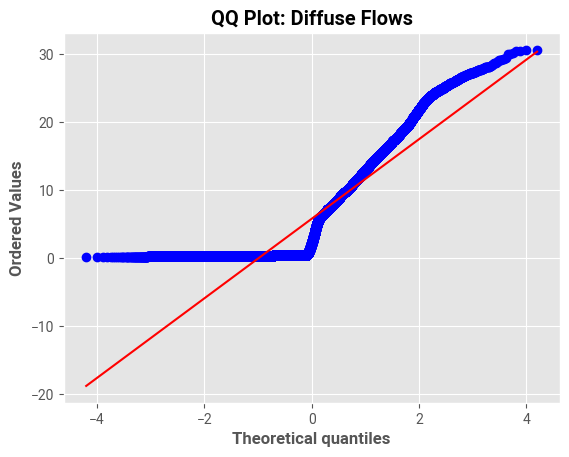

In [401]:
stats.probplot(np.sqrt(tetoun_power["diffuse_flows"]), plot=plt)
plt.title("QQ Plot: Diffuse Flows")
plt.show()

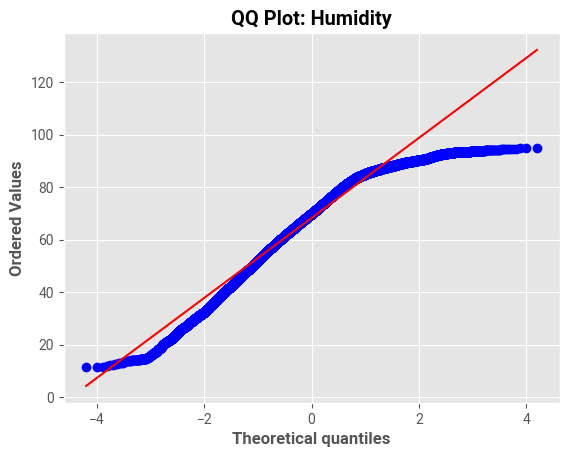

In [402]:
stats.probplot(tetoun_power["humidity"], plot=plt)
plt.title("QQ Plot: Humidity")
plt.show()

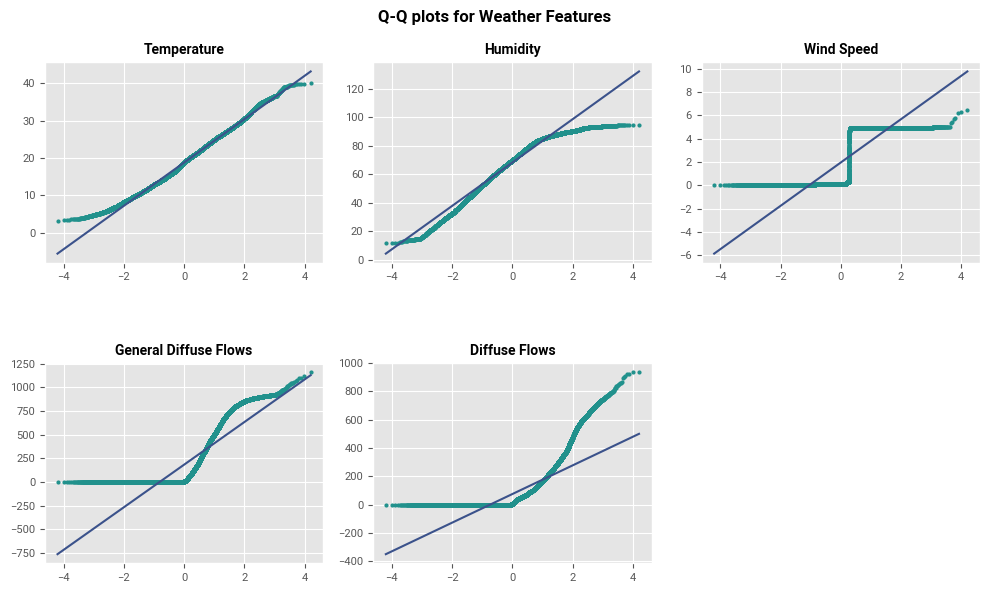

In [584]:
# QQ Plots for each weather feature
colors = viridis_cf(np.linspace(0, 1, len(common_feats)))

fig, ax = plt.subplots(2, 3, figsize=(10, 6))

ax_flat = ax.flatten()

[stats.probplot(tetoun_power[feat], plot=ax_flat[i])
 for i, feat in enumerate(common_feats)]

# Loop through styling
for i, axis in enumerate(ax_flat):
    try:
        axis.set_title(
            f"{common_feats[i].replace('_', ' ').title()}", fontsize=10)
        axis.get_lines()[0].set_markersize(2)
        axis.set_ylabel("")
        axis.set_xlabel("")
        axis.tick_params(axis='both', which='major', labelsize=8)
        axis.get_lines()[0].set_color(colors[2])
        axis.get_lines()[1].set_color(colors[1])

    except:
        pass

ax_flat[-1].axis('off')

fig.suptitle("Q-Q plots for Weather Features")
fig.tight_layout()
plt.subplots_adjust(hspace=0.5)
plt.show()

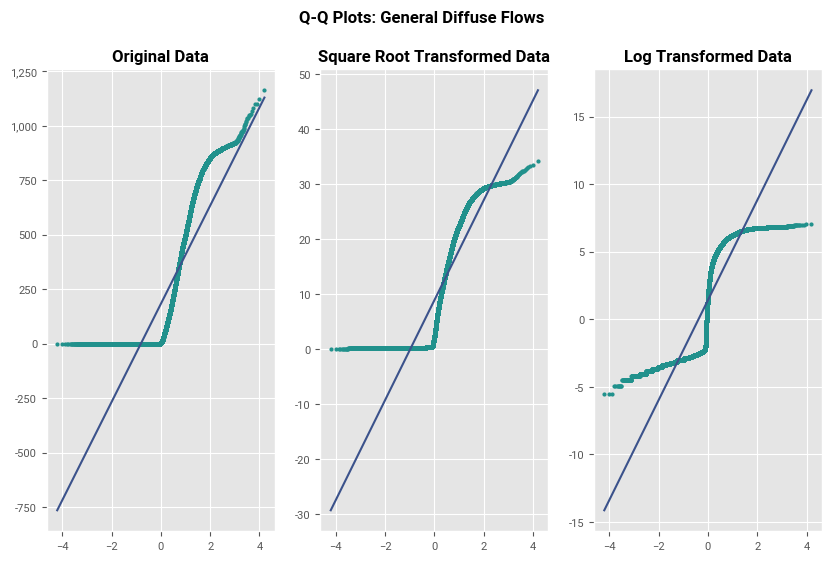

In [588]:
# General Diffuse flows adjustment
fig, ax = plt.subplots(1, 3, figsize=(10, 6))

pp = [stats.probplot(tetoun_power["general_diffuse_flows"], plot=ax[0]),
      stats.probplot(
          np.sqrt(tetoun_power["general_diffuse_flows"]), plot=ax[1]),
      stats.probplot(np.log(tetoun_power["general_diffuse_flows"]), plot=ax[2])]

ax[0].set_title("Original Data", fontsize=12)
ax[1].set_title("Square Root Transformed Data", fontsize=12)
ax[2].set_title("Log Transformed Data", fontsize=12)

# Loop through styling
for i, axis in enumerate(ax):
    try:
        axis.get_lines()[0].set_markersize(2)
        axis.set_ylabel("")
        axis.set_xlabel("")
        axis.tick_params(axis='both', which='major', labelsize=8)
        axis.get_lines()[0].set_color(colors[2])
        axis.get_lines()[1].set_color(colors[1])
        axis.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

    except:
        pass

fig.suptitle("Q-Q Plots: General Diffuse Flows")
plt.show()

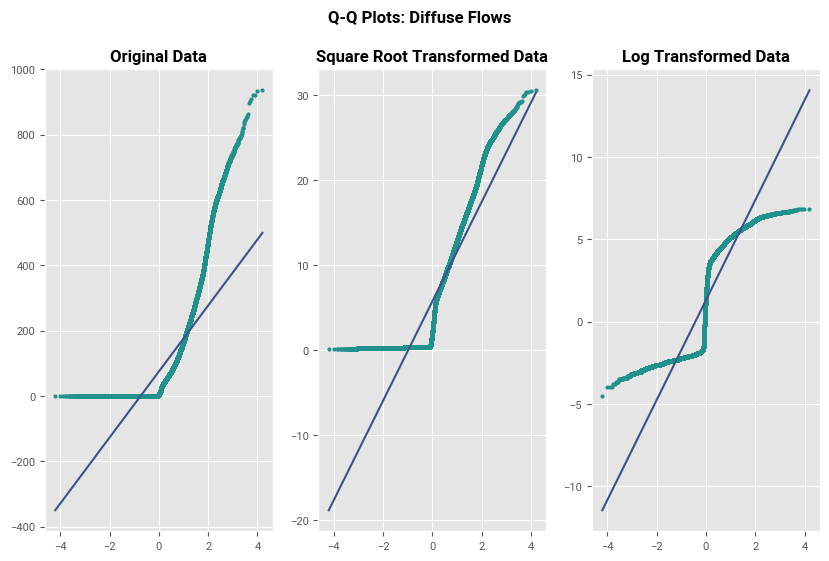

In [590]:
# Diffuse flows adjustment
fig, ax = plt.subplots(1, 3, figsize=(10, 6))

pp = [stats.probplot(tetoun_power["diffuse_flows"], plot=ax[0]),
      stats.probplot(np.sqrt(tetoun_power["diffuse_flows"]), plot=ax[1]),
      stats.probplot(np.log(tetoun_power["diffuse_flows"]), plot=ax[2])]

ax[0].set_title("Original Data", fontsize=12)
ax[1].set_title("Square Root Transformed Data", fontsize=12)
ax[2].set_title("Log Transformed Data", fontsize=12)

# Loop through styling
for i, axis in enumerate(ax):
    try:
        axis.get_lines()[0].set_markersize(2)
        axis.set_ylabel("")
        axis.set_xlabel("")
        axis.tick_params(axis='both', which='major', labelsize=8)
        axis.get_lines()[0].set_color(colors[2])
        axis.get_lines()[1].set_color(colors[1])
        ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

    except:
        pass

fig.suptitle("Q-Q Plots: Diffuse Flows")
plt.show()

/opt/anaconda3/envs/usd_ai/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/usd_ai/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


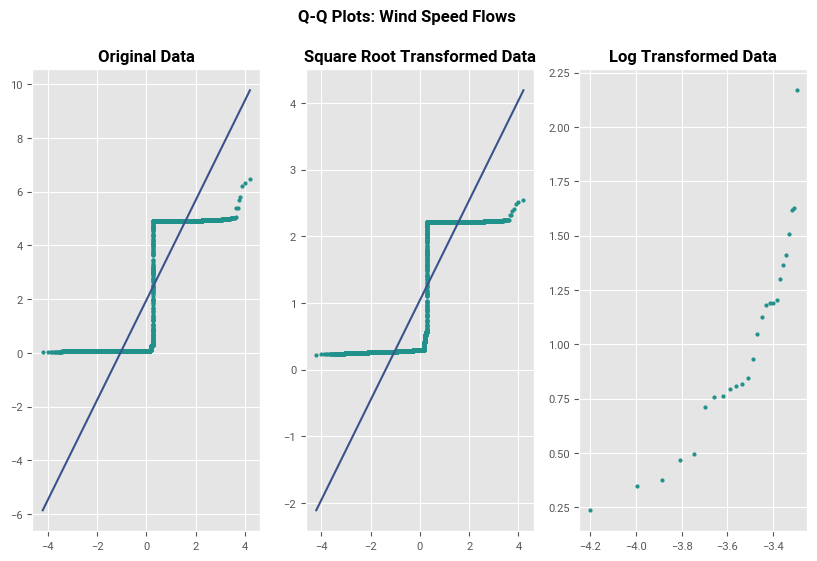

In [558]:
# Wind Speed adjustment
fig, ax = plt.subplots(1, 3, figsize=(10, 6))

pp = [stats.probplot(tetoun_power["wind_speed"], plot=ax[0]),
      stats.probplot(np.sqrt(tetoun_power["wind_speed"]), plot=ax[1]),
      stats.probplot(np.sqrt(np.log(tetoun_power["wind_speed"]/(1-tetoun_power["wind_speed"]))), plot=ax[2])]


ax[0].set_title("Original Data", fontsize=12)
ax[1].set_title("Square Root Transformed Data", fontsize=12)
ax[2].set_title("Log Transformed Data", fontsize=12)

# Loop through styling
for i, axis in enumerate(ax):
    try:
        axis.get_lines()[0].set_markersize(2)
        axis.set_ylabel("")
        axis.set_xlabel("")
        axis.tick_params(axis='both', which='major', labelsize=8)
        axis.get_lines()[0].set_color(colors[2])
        axis.get_lines()[1].set_color(colors[1])

    except:
        pass

fig.suptitle("Q-Q Plots: Wind Speed Flows")
plt.show()

In [555]:
np.log(tetoun_power["wind_speed"]/(1-tetoun_power["wind_speed"]))

/opt/anaconda3/envs/usd_ai/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


0       -2.402267
1       -2.402267
2       -2.442347
3       -2.402267
4       -2.428837
           ...   
52411   -2.442347
52412   -2.415478
52413   -2.363483
52414   -2.442347
52415   -2.428837
Name: wind_speed, Length: 52416, dtype: float64

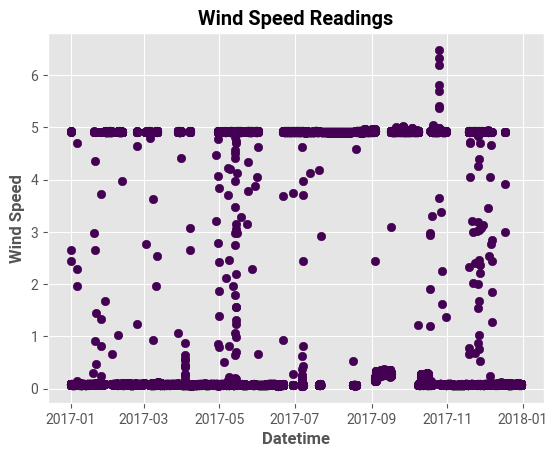

In [583]:
# Wind speed scatter
colors = viridis_cf(np.linspace(0, 1, 1))

fig, ax = plt.subplots()

ax.scatter(tetoun_power["datetime"],
           tetoun_power["wind_speed"], facecolors=colors)
ax.set_title("Wind Speed Readings")
ax.set_xlabel("Datetime")
ax.set_ylabel("Wind Speed")
plt.show()

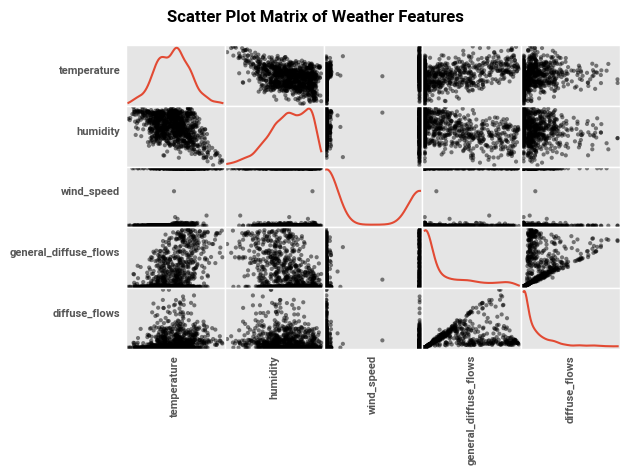

In [592]:
axes = pd.plotting.scatter_matrix(
    tetoun_power[common_feats].sample(n=1000), diagonal="kde", c="black")
for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.xaxis.label.set_fontsize(8)
    ax.set_xticks([])

    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_fontsize(8)
    ax.yaxis.label.set_ha('right')
    ax.set_yticks([])

plt.suptitle("Scatter Plot Matrix of Weather Features")
plt.tight_layout()
plt.gcf().subplots_adjust(wspace=0, hspace=0)
plt.show()

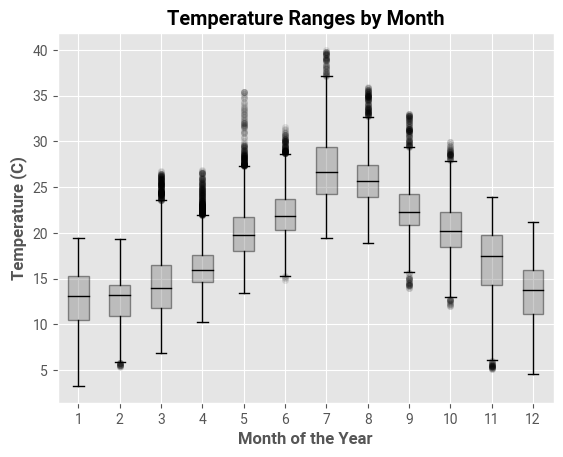

In [649]:
# Temperature by Month
fig, ax = plt.subplots()

ax.boxplot([tetoun_power["temperature"].loc[tetoun_power["month"] == i] for i in np.arange(1, 13)],
           patch_artist=True,
           boxprops=dict(facecolor="gray", alpha=0.4),
           flierprops=dict(alpha=0.1))

ax.set_xlabel("Month of the Year")
ax.set_ylabel("Temperature (C)")

plt.title("Temperature Ranges by Month")
plt.show()

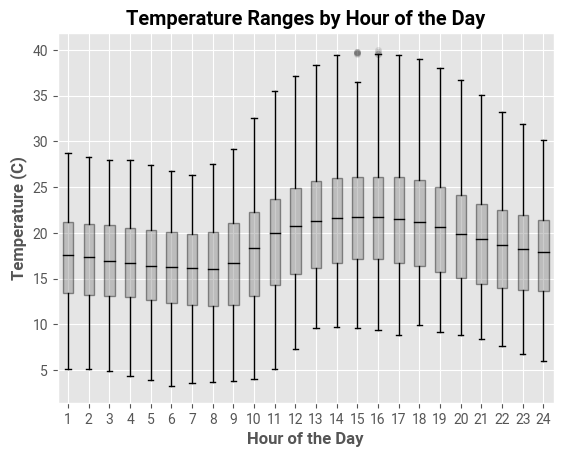

In [337]:
# Temperature by Hour
fig, ax = plt.subplots()

ax.boxplot([tetoun_power["temperature"].loc[tetoun_power["hour"] == i]
           for i in np.arange(0, 24)],
           patch_artist=True,
           boxprops=dict(facecolor="gray", alpha=0.4),
           flierprops=dict(alpha=0.1))

ax.set_xlabel("Hour of the Day")
ax.set_ylabel("Temperature (C)")

plt.title("Temperature Ranges by Hour of the Day")
plt.show()

# Regression Analysis

In [308]:
tetoun_power[zones + ["total_power"]].corr()

,zone_1_power,zone_2_power,zone_3_power,total_power
zone_1_power,1.000000,0.834519,0.750733,0.959146
zone_2_power,0.834519,1.000000,0.570932,0.871069
zone_3_power,0.750733,0.570932,1.000000,0.871777
total_power,0.959146,0.871069,0.871777,1.000000


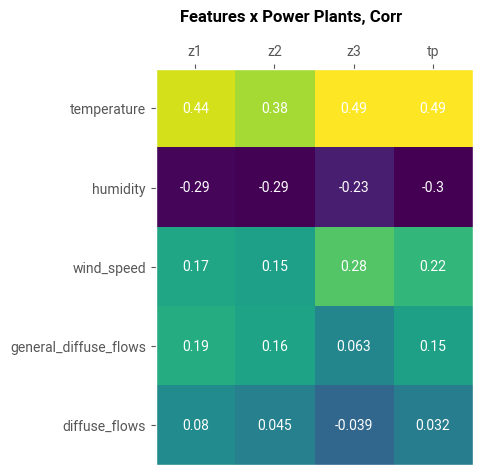

In [313]:
tp_corr = tetoun_power[common_feats+["total_power"]] \
    .corr().loc[pd.Index(common_feats), "total_power"]

z1_corr = tetoun_power[common_feats+["zone_1_power"]] \
    .corr().loc[pd.Index(common_feats), "zone_1_power"]

z2_corr = tetoun_power[common_feats+["zone_2_power"]] \
    .corr().loc[pd.Index(common_feats), "zone_2_power"]

z3_corr = tetoun_power[common_feats+["zone_3_power"]] \
    .corr().loc[pd.Index(common_feats), "zone_3_power"]

corr_df = pd.DataFrame({"z1": z1_corr, "z2": z2_corr,
                        "z3": z3_corr, "tp": tp_corr})

fig, ax = plt.subplots()

ax.imshow(corr_df)

ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
ax.set_xticks(np.arange(corr_df.shape[1]), labels=corr_df.columns)
ax.set_yticks(np.arange(corr_df.shape[0]), labels=common_feats)
ax.grid(False)

# Loop over data dimensions and create text annotations.
for i in range(corr_df.shape[0]):
    for j in range(corr_df.shape[1]):
        text = ax.text(j, i, f"{corr_df.iloc[i, j]:.2}",
                       ha="center", va="center", color="w")

plt.suptitle("Features x Power Plants, Corr")
plt.tight_layout()
plt.show()

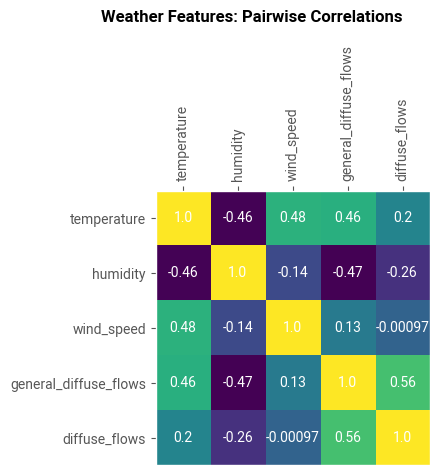

In [320]:
cf_corr = tetoun_power[common_feats].corr()

fig, ax = plt.subplots()

ax.imshow(cf_corr)

ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
ax.set_xticks(np.arange(cf_corr.shape[1]), labels=common_feats)
ax.set_yticks(np.arange(cf_corr.shape[0]), labels=common_feats)
ax.grid(False)

# Loop over data dimensions and create text annotations.
for i in range(cf_corr.shape[0]):
    for j in range(cf_corr.shape[1]):
        text = ax.text(j, i, f"{cf_corr.iloc[i, j]:.2}",
                       ha="center", va="center", color="w")

plt.xticks(rotation=90)
plt.suptitle("Weather Features: Pairwise Correlations")
plt.tight_layout()
plt.show()

In [203]:
# Dataframe of Cosine Similarities
cs_df = pd.DataFrame(metrics.pairwise.cosine_similarity(corr_df.T))
cs_df.columns = ["z1", "z2", "z3", "tp"]
cs_df.index = ["z1", "z2", "z3", "tp"]

cs_df

,z1,z2,z3,tp
z1,1.000000,0.995680,0.935337,0.990414
z2,0.995680,1.000000,0.936256,0.990187
z3,0.935337,0.936256,1.000000,0.974533
tp,0.990414,0.990187,0.974533,1.000000


In [616]:
# Multiple Linear Regression: Zone 1
mv_lm_zone_1 = smf.ols(formula="zone_1_power ~ \
                       month + day_of_week + hour + \
                       temperature + humidity + np.log(wind_speed) + \
                       general_diffuse_flows + np.sqrt(diffuse_flows)",
                       data=tetoun_power).fit()


# Multiple Linear Regression: Zone 2
mv_lm_zone_2 = smf.ols(formula="zone_2_power ~ \
                       month + day_of_week + hour + \
                       temperature + humidity + wind_speed + \
                       general_diffuse_flows + diffuse_flows",
                       data=tetoun_power).fit()


# Multiple Linear Regression: Zone 3
mv_lm_zone_3 = smf.ols(formula="zone_3_power ~ \
                       month + day_of_week + hour + \
                       temperature + humidity + wind_speed + \
                       general_diffuse_flows + diffuse_flows",
                       data=tetoun_power).fit()

# Multiple Linear Regression: Total Power
mv_lm_total_power = smf.ols(formula="total_power ~ \
                       month + day_of_week + hour + \
                       temperature + humidity + wind_speed + \
                       general_diffuse_flows + diffuse_flows",
                       data=tetoun_power).fit()

print(mv_lm_zone_1.summary2())

                        Results: Ordinary least squares
Model:                   OLS                 Adj. R-squared:        0.646       
Dependent Variable:      zone_1_power        AIC:                   1024382.7457
Date:                    2024-10-19 21:40    BIC:                   1024462.5484
No. Observations:        52416               Log-Likelihood:        -5.1218e+05 
Df Model:                8                   F-statistic:           1.197e+04   
Df Residuals:            52407               Prob (F-statistic):    0.00        
R-squared:               0.646               Scale:                 1.7989e+07  
--------------------------------------------------------------------------------
                         Coef.    Std.Err.    t     P>|t|    [0.025     0.975]  
--------------------------------------------------------------------------------
Intercept              18572.9414 158.6560 117.0642 0.0000 18261.9741 18883.9087
month                   -253.4262   5.7587 -44.0073 0

In [206]:
print(mv_lm_zone_2.summary2())

                        Results: Ordinary least squares
Model:                   OLS                 Adj. R-squared:        0.594      
Dependent Variable:      zone_2_power        AIC:                   998474.7431
Date:                    2024-10-19 15:04    BIC:                   998554.5458
No. Observations:        52416               Log-Likelihood:        -4.9923e+05
Df Model:                8                   F-statistic:           9603.      
Df Residuals:            52407               Prob (F-statistic):    0.00       
R-squared:               0.594               Scale:                 1.0974e+07 
-------------------------------------------------------------------------------
                        Coef.    Std.Err.    t     P>|t|    [0.025     0.975]  
-------------------------------------------------------------------------------
Intercept             13679.7751 118.6295 115.3151 0.0000 13447.2601 13912.2901
month                   406.3028   4.5076  90.1371 0.0000   397.

In [207]:
print(mv_lm_zone_3.summary2())

                       Results: Ordinary least squares
Model:                  OLS                Adj. R-squared:       0.601       
Dependent Variable:     zone_3_power       AIC:                  1022897.6753
Date:                   2024-10-19 15:04   BIC:                  1022977.4780
No. Observations:       52416              Log-Likelihood:       -5.1144e+05 
Df Model:               8                  F-statistic:          9880.       
Df Residuals:           52407              Prob (F-statistic):   0.00        
R-squared:              0.601              Scale:                1.7487e+07  
-----------------------------------------------------------------------------
                        Coef.   Std.Err.     t     P>|t|    [0.025    0.975] 
-----------------------------------------------------------------------------
Intercept             5947.5687 149.7516   39.7162 0.0000 5654.0542 6241.0831
month                 -871.3437   5.6902 -153.1316 0.0000 -882.4965 -860.1909
day_of_we

In [208]:
print(mv_lm_total_power.summary())

                            OLS Regression Results                            
Dep. Variable:            total_power   R-squared:                       0.634
Model:                            OLS   Adj. R-squared:                  0.634
Method:                 Least Squares   F-statistic:                 1.133e+04
Date:                Sat, 19 Oct 2024   Prob (F-statistic):               0.00
Time:                        15:04:41   Log-Likelihood:            -5.5908e+05
No. Observations:               52416   AIC:                         1.118e+06
Df Residuals:                   52407   BIC:                         1.118e+06
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              3.794e+

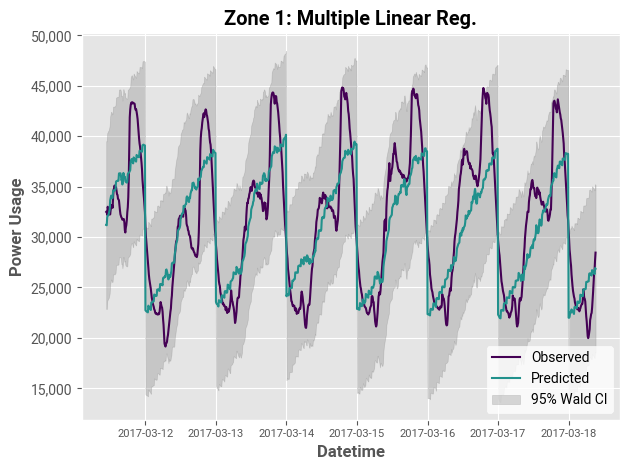

In [647]:
sample = tetoun_power[10000:11000]

colors = viridis_cf(np.linspace(0, 1, 3))

pred = mv_lm_zone_1.get_prediction(sample).summary_frame()

fig, ax = plt.subplots()

ax.plot(sample["datetime"], sample["zone_1_power"], color=colors[0], label="Observed")
ax.plot(sample["datetime"], pred["mean"], color=colors[1], label="Predicted")

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
[i.set_fontsize(8) for i in ax.get_xticklabels()]
ax.set_xlabel("Datetime")
ax.set_ylabel("Power Usage")
ax.set_title("Zone 1: Multiple Linear Reg.")

plt.fill_between(sample["datetime"], pred["obs_ci_lower"], pred["obs_ci_upper"], where=(
    pred["obs_ci_lower"] <= pred["obs_ci_upper"]), interpolate=True, color='gray', alpha=0.3, label="95% Wald CI")

plt.legend()
fig.tight_layout()
plt.show()

In [210]:
# Accuracy measures for Zone 1 MV LM
metrics.mean_absolute_percentage_error(tetoun_power["zone_1_power"],
                                       mv_lm_zone_1.predict(tetoun_power))

0.10817738511276011

In [211]:
# Fitting a Ridge Regression
y = tetoun_power["zone_1_power"]
X = tetoun_power[["month", "day_of_week", "hour", "temperature",
                  "humidity", "wind_speed", "general_diffuse_flows", "diffuse_flows"]]

z1_rr = sklm.RidgeCV(alphas=list(np.linspace(100, 1000, num=10000))).fit(X, y)
# z1_rr = sklm.RidgeCV(alphas=[1.0e-3]).fit(X, y)

z1_rr.score(X, y)

0.6441247837446175

In [212]:
# Learned Regularization parameter
z1_rr.alpha_

315.66156615661566

In [618]:
z1_rr.

array([-2.53062682e+02, -2.35614011e+02,  6.92659899e+02,  4.45245337e+02,
        5.60278762e+00,  5.48694672e+01, -4.90541477e-01, -4.77371515e+00])

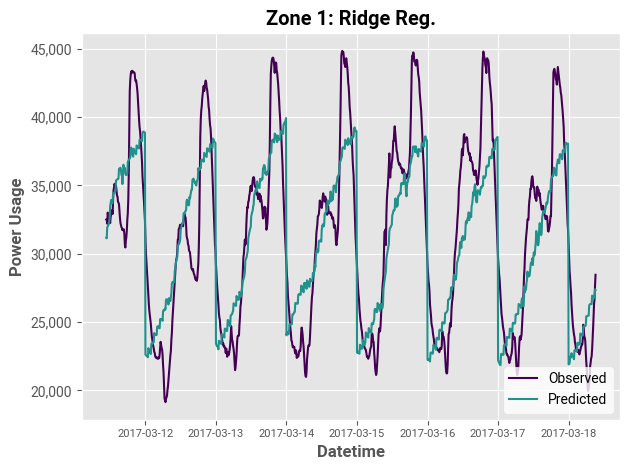

In [646]:
# Zone 1: Ridge Regression
sample = X[10000:11000]
dates = tetoun_power["datetime"][10000:11000]

pred = z1_rr.predict(sample)
output_space = np.linspace(0,  999, num=1000)

fig, ax = plt.subplots()

ax.plot(dates, y[10000:11000], color=colors[0], label="Observed")
ax.plot(dates, pred, color=colors[1], label="Predicted")


ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
[i.set_fontsize(8) for i in ax.get_xticklabels()]
ax.set_xlabel("Datetime")
ax.set_ylabel("Power Usage")
ax.set_title("Zone 1: Ridge Reg.")


plt.legend(loc='lower right')
fig.tight_layout()
plt.show()

In [214]:
# Multiple Linear Regression: Zone 1 (Version 2)
mv_lm_zone_1_2 = smf.ols(formula="zone_1_power ~ \
                       hour ",
                         data=tetoun_power).fit()

In [215]:
mv_lm_zone_1_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           zone_1_power   R-squared:                       0.530
Model:                            OLS   Adj. R-squared:                  0.530
Method:                 Least Squares   F-statistic:                 5.908e+04
Date:                Sat, 19 Oct 2024   Prob (F-statistic):               0.00
Time:                        15:04:58   Log-Likelihood:            -5.1963e+05
No. Observations:               52416   AIC:                         1.039e+06
Df Residuals:                   52414   BIC:                         1.039e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.372e+04     41.407    572.883      0.000    2.36e+04    2.38e+04
hour         749.8586      3.085    243.074      0.000     743.812     755.905
==============================================================================
Omnibus:                     1362.529   Durbin-Watson:                   0.099
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1517.862
Skew:                           0.376   Prob(JB):                         0.00
Kurtosis:                       3.359   Cond. No.                         26.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

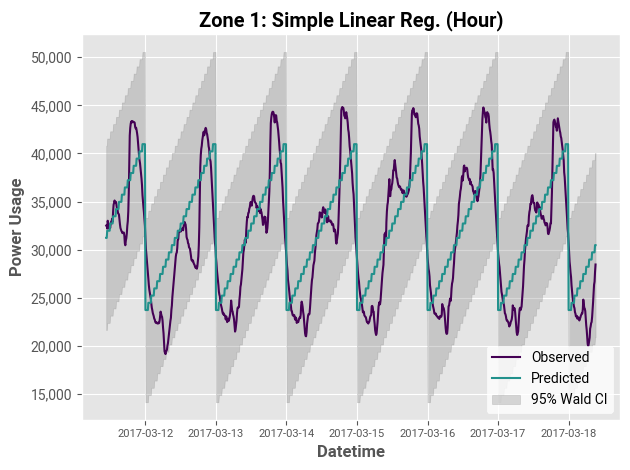

In [645]:
# Simple model
sample = tetoun_power[10000:11000]

pred = mv_lm_zone_1_2.get_prediction(sample).summary_frame()

fig, ax = plt.subplots()

ax.plot(sample["datetime"], sample["zone_1_power"], color=colors[0], label="Observed")
ax.plot(sample["datetime"], pred["mean"], color=colors[1], label="Predicted")

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
[i.set_fontsize(8) for i in ax.get_xticklabels()]
ax.set_xlabel("Datetime")
ax.set_ylabel("Power Usage")
ax.set_title("Zone 1: Simple Linear Reg. (Hour)")

plt.fill_between(sample["datetime"], pred["obs_ci_lower"], pred["obs_ci_upper"], where=(
    pred["obs_ci_lower"] <= pred["obs_ci_upper"]), interpolate=True, color='gray', alpha=0.3, label="95% Wald CI")

plt.legend(loc="lower right")
fig.tight_layout()
plt.show()

In [217]:
# Calculate the log-likelihood
def log_likelihood(model, y, X):
    k = len(model.coef_) + 1
    n = len(y)

    residuals = y - model.predict(X)
    mse = metrics.mean_squared_error(y, model.predict(X))
    return k, -n/2 * np.log(2*np.pi) - n/2 * np.log(mse) - 1/(2*mse) * np.sum(residuals**2)


def aic(model, y, X):
    k, ll = log_likelihood(model, y, X)
    return 2*k - 2*ll

In [218]:
# Comparing AIC

print(f"AIC RR: {aic(z1_rr, y, X)}")
print(f"AIC MVLM: {mv_lm_zone_1.aic}")

AIC RR: 1024697.0046720345
AIC MVLM: 1024382.7456707802


In [219]:
pred_zone_sums = \
    mv_lm_zone_1.predict(tetoun_power) + \
    mv_lm_zone_1.predict(tetoun_power) + \
    mv_lm_zone_1.predict(tetoun_power)

pred_tp = mv_lm_total_power.predict(tetoun_power)

print(metrics.mean_absolute_percentage_error(tetoun_power["total_power"],
                                             pred_zone_sums))

print(metrics.mean_absolute_percentage_error(tetoun_power["total_power"],
                                             pred_tp))

print()
print(metrics.explained_variance_score(tetoun_power["total_power"],
                                       pred_zone_sums))

print(metrics.explained_variance_score(tetoun_power["total_power"],
                                       pred_tp))

print()
print(np.sqrt(metrics.mean_squared_error(tetoun_power["total_power"],
                                         pred_zone_sums)))

print(np.sqrt(metrics.mean_squared_error(tetoun_power["total_power"],
                                         pred_tp)))

0.39776456045724107
0.11916965346437886

0.5818414100037006
0.633633488304588

28091.810115270906
10376.33746079026


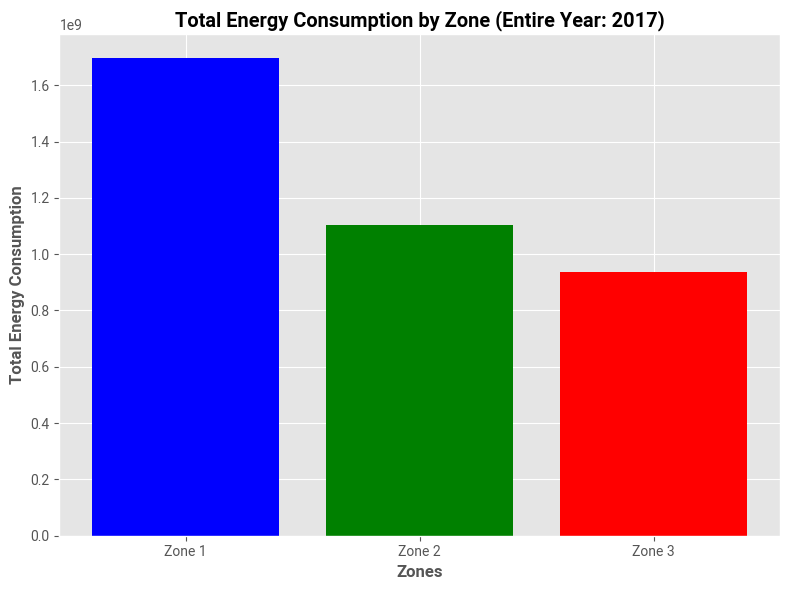

In [220]:
# Summing the total energy consumption for each zone over the entire year
total_consumption = {
    "Zone 1": tetoun_power["zone_1_power"].sum(),
    "Zone 2": tetoun_power["zone_2_power"].sum(),
    "Zone 3": tetoun_power["zone_3_power"].sum()
}

# Create a bar chart
fig, ax = plt.subplots(figsize=(8, 6))

ax.bar(total_consumption.keys(), total_consumption.values(),
       color=['blue', 'green', 'red'])

# Add titles and labels
ax.set_title('Total Energy Consumption by Zone (Entire Year: 2017)')
ax.set_xlabel('Zones')
ax.set_ylabel('Total Energy Consumption')

# Display the bar chart
plt.tight_layout()
plt.show()

In [221]:
""" # Set 'datetime' as the index for time-based operations
tetoun_power.set_index('datetime', append=True)

# Resample the data to a monthly frequency and calculate the average power consumption per month
monthly_consumption = tetoun_power.resample(
    'W').mean()[["zone_1_power", "zone_2_power", "zone_3_power"]]

# Calculate a 3-month rolling mean to smooth out short-term fluctuations
rolling_avg = monthly_consumption.rolling(window=3).mean()

# Plot the monthly average power consumption for each zone along with the rolling average
plt.figure(figsize=(12, 6))

# Zone 1
plt.plot(monthly_consumption.index,
         monthly_consumption["zone_1_power"], label="Zone 1 Power - Monthly", color="blue", alpha=0.6)
plt.plot(rolling_avg.index, rolling_avg["zone_1_power"],
         label="Zone 1 Power - Trend (3-month avg)", color="blue", linestyle="--")

# Zone 2
plt.plot(monthly_consumption.index,
         monthly_consumption["zone_2_power"], label="Zone 2 Power - Monthly", color="green", alpha=0.6)
plt.plot(rolling_avg.index, rolling_avg["zone_2_power"],
         label="Zone 2 Power - Trend (3-month avg)", color="green", linestyle="--")

# Zone 3
plt.plot(monthly_consumption.index,
         monthly_consumption["zone_3_power"], label="Zone 3 Power - Monthly", color="red", alpha=0.6)
plt.plot(rolling_avg.index, rolling_avg["zone_3_power"],
         label="Zone 3 Power - Trend (3-month avg)", color="red", linestyle="--")

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Power Consumption')
plt.title('Monthly Power Consumption Trend for Each Zone')
plt.legend()
plt.tight_layout()

# Show the plot
plt.show() """

' # Set \'datetime\' as the index for time-based operations\ntetoun_power.set_index(\'datetime\', append=True)\n\n# Resample the data to a monthly frequency and calculate the average power consumption per month\nmonthly_consumption = tetoun_power.resample(\n    \'W\').mean()[["zone_1_power", "zone_2_power", "zone_3_power"]]\n\n# Calculate a 3-month rolling mean to smooth out short-term fluctuations\nrolling_avg = monthly_consumption.rolling(window=3).mean()\n\n# Plot the monthly average power consumption for each zone along with the rolling average\nplt.figure(figsize=(12, 6))\n\n# Zone 1\nplt.plot(monthly_consumption.index,\n         monthly_consumption["zone_1_power"], label="Zone 1 Power - Monthly", color="blue", alpha=0.6)\nplt.plot(rolling_avg.index, rolling_avg["zone_1_power"],\n         label="Zone 1 Power - Trend (3-month avg)", color="blue", linestyle="--")\n\n# Zone 2\nplt.plot(monthly_consumption.index,\n         monthly_consumption["zone_2_power"], label="Zone 2 Power - Mon

In [222]:
# Hypothetical mean value to compare against
hypothetical_mean = 32300

# One-sample t-test for Zone 1 power consumption
t_statistic, p_value = stats.ttest_1samp(
    tetoun_power['zone_1_power'], hypothetical_mean)

print(f"""One-sample t-test for Zone 1 Power Consumption

Testing whether the mean power consumption in Zone 1 differs significantly from a hypothetical value, {hypothetical_mean} in this case.

H0:μ Zone1 = {hypothetical_mean}
H1:μ Zone1 >/< {hypothetical_mean}
""")
print(f"t-statistic: {t_statistic:.4f}, p-value: {p_value:.4f}")

# Interpretation
if p_value < 0.05:
    print("The result is statistically significant. We reject the null hypothesis.")
else:
    print("The result is not statistically significant. We fail to reject the null hypothesis.")

One-sample t-test for Zone 1 Power Consumption

Testing whether the mean power consumption in Zone 1 differs significantly from a hypothetical value, 32300 in this case.

H0:μ Zone1 = 32300
H1:μ Zone1 >/< 32300

t-statistic: 1.4439, p-value: 0.1488
The result is not statistically significant. We fail to reject the null hypothesis.


In [223]:
# Two-sample t-test between Zone 1 and Zone 2
t_statistic, p_value = stats.ttest_ind(
    tetoun_power['zone_1_power'], tetoun_power['zone_2_power'])

print(f"""Two-sample t-test between Zone 1 and Zone 2 Power Consumption

Testing whether the mean power consumption in Zone 1 is significantly different from that in Zone 2.

H0:μ Zone1 = μ Zone2
H1:μ Zone1 >/< μ Zone2
""")
print(f"t-statistic: {t_statistic:.4f}, p-value: {p_value:.4f}")

# Interpretation
if p_value < 0.05:
    print("The result is statistically significant. We reject the null hypothesis.")
else:
    print("The result is not statistically significant. We fail to reject the null hypothesis.")

Two-sample t-test between Zone 1 and Zone 2 Power Consumption

Testing whether the mean power consumption in Zone 1 is significantly different from that in Zone 2.

H0:μ Zone1 = μ Zone2
H1:μ Zone1 >/< μ Zone2

t-statistic: 293.1810, p-value: 0.0000
The result is statistically significant. We reject the null hypothesis.


In [224]:
# ANOVA test across Zone 1, Zone 2, and Zone 3
f_statistic, p_value = stats.f_oneway(tetoun_power['zone_1_power'],
                                      tetoun_power['zone_2_power'],
                                      tetoun_power['zone_3_power'])

print(f"""ANOVA test across Zone 1, Zone 2, and Zone 3 Power Consumption.

Test whether there is a significant difference in the mean power consumption across Zone 1, Zone 2, and Zone 3.

H0:μ Zone1 = μ Zone2 = μ Zone3
H1:At least one μ is different.
""")
print(f"F-statistic: {f_statistic:.4f}, p-value: {p_value:.4f}")

# Interpretation
if p_value < 0.05:
    print("The result is statistically significant. We reject the null hypothesis.")
else:
    print("The result is not statistically significant. We fail to reject the null hypothesis.")

ANOVA test across Zone 1, Zone 2, and Zone 3 Power Consumption.

Test whether there is a significant difference in the mean power consumption across Zone 1, Zone 2, and Zone 3.

H0:μ Zone1 = μ Zone2 = μ Zone3
H1:At least one μ is different.

F-statistic: 75028.9996, p-value: 0.0000
The result is statistically significant. We reject the null hypothesis.
